# The objective of the assignment is to compute the reliability of a wind turbine blade against fatigue failure in its root section. It requires defining a limit state function and estimating the probability of failure based on different environmental and material variables

In [109]:
# Importing libraries once

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import scipy
from pandas.plotting import scatter_matrix
import seaborn as sns
from windrose import WindroseAxes

## Two datasets are provided: 
 - Hovsore = 10-minute average wind speeds, directions, turbulence at Høvsøre over 10 
years, including timestamp
 - DEL = data of simulated 10-minute realizations of damage 
equivalent loads (DEL) for the DTU 10MW reference wind turbine as function of various external 
conditions, including wind speed, turbulence, wind shear.

In [110]:
# Directory containing the files (current working directory)
current_dir = os.getcwd()  # gets the path of the folder where the code is run
Hovsore_data_filepath = os.path.join(current_dir, 'HovsoreData_Sonic_100m_2004-2013.csv')

# Load Hovsore wind data CSV
Hovsore_data = pd.read_csv(Hovsore_data_filepath)

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir
0,200410010000,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044
1,200410010020,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949
2,200410010030,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588
3,200410010040,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953
4,200410010050,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960


# Data preparation

## Filtering: Treating the data to remove any outlier(i.e. removing the wind speeds any higher than 45 m/s) 

In [111]:
# Optimization 1: Efficient data cleaning with vectorized operations and interpolation
def clean_data(df):
    # Replacing windspeeds greater than 45 with NaN
    df['Wsp'] = np.where(df['Wsp'] > 45, np.nan, df['Wsp'])
    
    # Replacing turbulence intensity (TI) values with NaN
    df['TI'] = np.where((df['TI'] > 1.0) | (df['TI'] <= 0), pd.NA, df['TI'])
    df['TI,detrend'] = np.where(df['TI,detrend'] <= 1.5, np.nan, df['TI,detrend'])
    # Using interpolation instead of backward fill to handle missing data
    df_cleaned = df.interpolate(method='linear', limit_direction='both')
    
    # Creating a new feature 'SigmaU' as the product of Wsp and TI
    df_cleaned['SigmaU'] = df_cleaned['Wsp'] * df_cleaned['TI']
    
    return df_cleaned.dropna()

# Apply data cleaning on the dataset
Hovsore_clean_data = clean_data(Hovsore_data)

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir
0,200410010000,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044
1,200410010020,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949
2,200410010030,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588
3,200410010040,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953
4,200410010050,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960


## Visualization

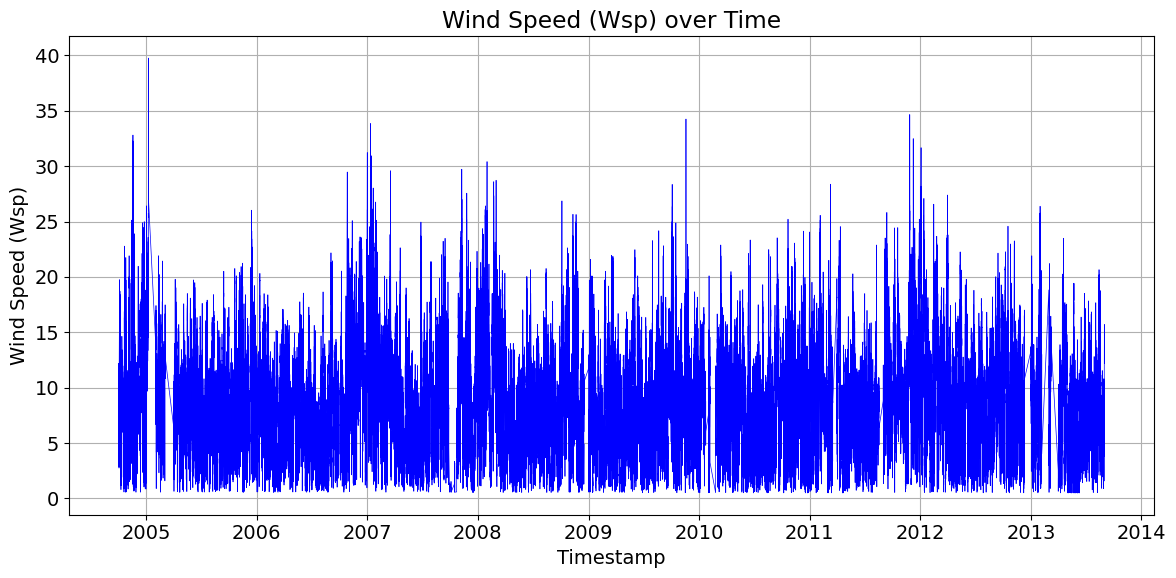

In [112]:
# Convert the Timestamp column to datetime format
'''
Hovsore_filtered_data['Timestamp'] = pd.to_datetime(Hovsore_filtered_data['Timestamp'], format='%Y%m%d%H%M')

# Plotting Wsp against Timestamp
plt.figure(figsize=(12, 6))
plt.plot(Hovsore_filtered_data['Timestamp'], Hovsore_filtered_data['Wsp'], color='blue', linewidth=0.5)
plt.title('Wind Speed (Wsp) over Time')
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (Wsp)')
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()
'''

## Fit a marginal Weibull distribution to the wind speed

In [113]:
# WIND SPEED DISTRIBUTION FIT
# Weibull distribution fit using the max-likelihood method
Wsp0 = np.asarray(Hovsore_filtered_data['Wsp'])

WeibLikelihoodFunc = lambda theta: -np.sum( stats.weibull_min.logpdf(Wsp0,c = theta[1],scale=theta[0]) )
Weib0 = scipy.optimize.minimize(WeibLikelihoodFunc,[2,1])

WeibullA = Weib0.x[0]
Weibullk = Weib0.x[1]

print('Distribution parameters using the max-likelihood method: A = ' + str(Weib0.x[0]) + ', k = ' + str(Weib0.x[1]))

Distribution parameters using the max-likelihood method: A = 9.98256948470993, k = 2.0325587954422955


In [ ]:
# Create a histogram of the wind speed data
counts1, bin_edges1 = np.histogram(Wsp0, bins=50, density=True)
bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2

# Calculate the Weibull distribution for the estimated parameters
pdf_weibull_fit1 = stats.weibull_min.pdf(bin_centers1, c=Weibullk, scale=WeibullA)

# Plot the histogram and the fitted Weibull distribution
plt.figure(figsize=(8, 6))
plt.bar(bin_centers1, counts1, width=np.diff(bin_edges1), alpha=0.6, color='grey', label="Wind Data Histogram", edgecolor='black')
plt.plot(bin_centers1, pdf_weibull_fit1, 'r-', label=f'Weibull Fit: A={WeibullA:.2f}, k={Weibullk:.2f}', lw=2)
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Probability Density')
plt.title('Wind Speed Data and Weibull Fit')
plt.legend()
plt.show()

## Fit a conditional LogNormal distribution to the turbulence, considering a linear or quadratic dependence of the mean turbulence to the wind speed

In [114]:
# Helper function - Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

In [115]:
# CONDITION DISTRIBUTION OF TURBULENCE - BASED ON DATA BINNING
WspBinEdges = np.arange(3.5,33.5,1)
WspBinCenters = WspBinEdges[:-1] + 0.5

MuSigmaBinned = np.zeros(len(WspBinCenters))
SigmaSigmaBinned = np.zeros(len(WspBinCenters))

nData = len( Hovsore_filtered_data['Wsp'])
    
# Per wind speed
for iWsp in range(len(WspBinCenters)):
    WspBinSelection = ( Hovsore_filtered_data['Wsp'] > WspBinEdges[iWsp]) & ( Hovsore_filtered_data['Wsp'] <= WspBinEdges[iWsp + 1])
    MuSigmaBinned[iWsp] = np.mean(Hovsore_filtered_data.loc[WspBinSelection,'SigmaU'])
    SigmaSigmaBinned[iWsp] = np.std(Hovsore_filtered_data.loc[WspBinSelection,'SigmaU'])
    
Mudatax = WspBinCenters[~np.isnan(MuSigmaBinned)]
Mudatay = MuSigmaBinned[~np.isnan(MuSigmaBinned)]
SigmaSigmaBinned = SigmaSigmaBinned[~np.isnan(MuSigmaBinned)]

# Use polyfit (for example np.polyfit). Which order works well - 0, 1, or 2?
# You can choose the order of the polynomial (0 for constant, 1 for linear, 2 for quadratic)
pMu = np.polyfit(Mudatax, Mudatay, deg=2)


SigmaSigmaRef = np.mean(SigmaSigmaBinned)
        
MuSigmaFunc = lambda u: np.polyval(pMu, u)
SigmaSigmaFunc = lambda u:  SigmaSigmaRef #np.ones(shape = np.shape(u)) * SigmaSigmaRef


In [116]:
Urand = stats.weibull_min.rvs(c= Weibullk, scale = WeibullA, size = 10000)
MuSigmaUrand = MuSigmaFunc(Urand)
Sigma_Urand = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.rand(10000), MuSigmaUrand, Sigma_Urand)

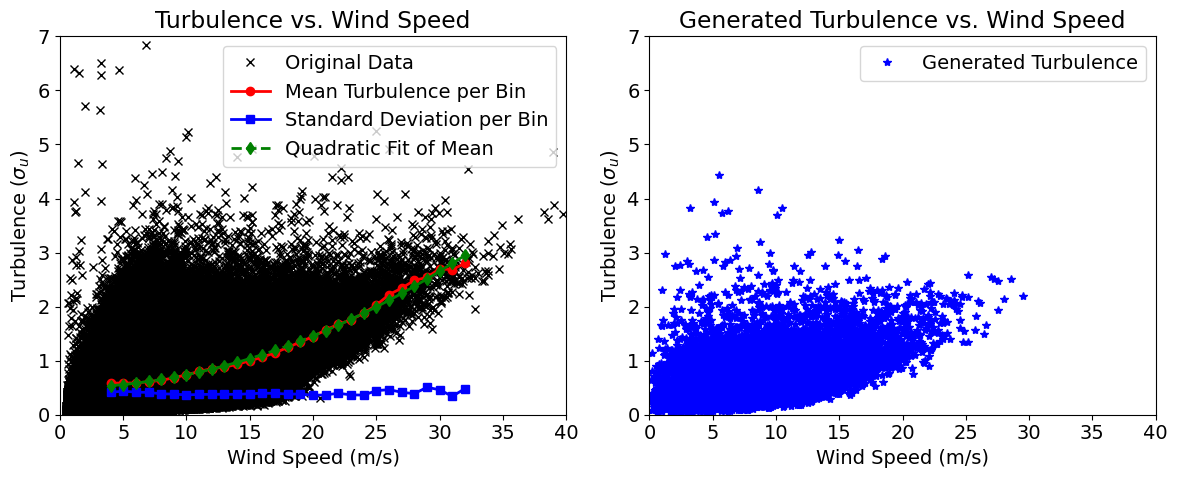

In [117]:
# PLOT TURBULENCE INCLUDING DISTRIBUTION PARAMETERS

fig,ax = plt.subplots(1,2, figsize = (12,5))
# Left plot: Relationship between wind speed and turbulence
ax[0].plot(Hovsore_filtered_data['Wsp'], Hovsore_filtered_data['SigmaU'], 'xk', label='Original Data')
ax[0].plot(WspBinCenters, MuSigmaBinned, '-r', label='Mean Turbulence per Bin',linewidth=2, marker='o', markersize=6)
ax[0].plot(WspBinCenters, SigmaSigmaBinned, '-b', label='Standard Deviation per Bin',linewidth=2, marker='s',markersize=6)
ax[0].plot(WspBinCenters, MuSigmaFunc(WspBinCenters), '--g', label='Quadratic Fit of Mean',linewidth=2, marker='d', markersize=6)
ax[0].set_xlim([0, 40])
ax[0].set_ylim([0, 7])
ax[0].set_xlabel('Wind Speed (m/s)')
ax[0].set_ylabel(r'Turbulence ($\sigma_u$)')
ax[0].set_title('Turbulence vs. Wind Speed')
ax[0].legend()

# Right plot: Generated turbulence values vs wind speed
ax[1].plot(Urand, SigmaUrand, '*b', label='Generated Turbulence')
ax[1].set_xlim([0, 40])
ax[1].set_ylim([0, 7])
ax[1].set_xlabel('Wind Speed (m/s)')
ax[1].set_ylabel(r'Turbulence ($\sigma_u$)')
ax[1].set_title('Generated Turbulence vs. Wind Speed')
ax[1].legend()

# Show the plot
plt.tight_layout()
plt.show()

## Determine the probability distribution of the wind climate uncertainty variable $X_w$ by analyzing the wind data through bootstrapping, further incorporating a 1% uncertainty for wind speed measurement and 1% for the joint-distribution fit.

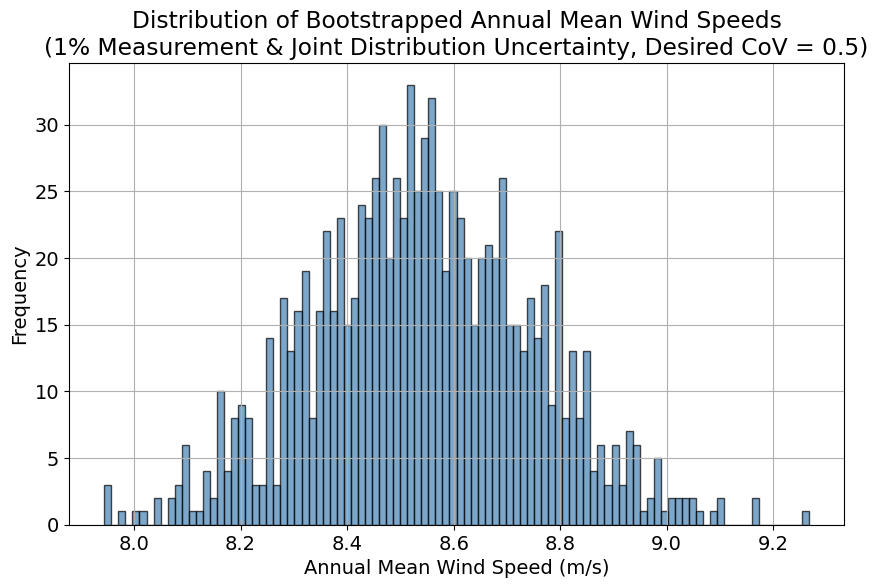

Ensemble Statistics with All Uncertainties Included:
Mean: 8.54 m/s
Standard Deviation: 0.21 m/s
Coefficient of Variation: 0.02


In [118]:
Hovsore_filtered_data['Year'] = Hovsore_filtered_data['Timestamp'].dt.year

# Step 1: Introduce 1% uncertainty for wind speed measurement
# Calculate 1% of each wind speed value and create random noise
measurement_noise = np.random.normal(loc=0, scale=0.01 * Hovsore_filtered_data['Wsp'], size=Hovsore_filtered_data['Wsp'].shape)
Hovsore_filtered_data['Wsp_with_uncertainty'] = Hovsore_filtered_data['Wsp'] + measurement_noise

# Step 2: Define a joint distribution of wind speed and another relevant variable, e.g., wind direction
# Let's assume wind speed and wind direction are joint variables for demonstration purposes
wind_speed = Hovsore_filtered_data['Wsp_with_uncertainty'].values
turbulence = Hovsore_filtered_data['SigmaU'].values

# Calculate the mean and covariance matrix for the joint distribution
joint_mean = np.array([np.mean(wind_speed), np.mean(turbulence)])
cov_matrix = np.cov(wind_speed, turbulence)

# Step 3: Add 1% uncertainty to the joint distribution fit
# Create random noise for the joint distribution fit
joint_noise = np.random.multivariate_normal([0, 0], cov_matrix * 0.01, size=len(wind_speed))

# Add the joint noise to wind speed and direction
wind_speed_with_joint_uncertainty = wind_speed + joint_noise[:, 0]
turbulence_with_joint_uncertainty = turbulence + joint_noise[:, 1]

# Create a new DataFrame to hold the joint variables with added uncertainty
Hovsore_filtered_data['Wsp_joint_uncertainty'] = wind_speed_with_joint_uncertainty
Hovsore_filtered_data['SigmaU_joint_uncertainty'] = turbulence_with_joint_uncertainty

# Step 4: Adjust the wind speed data to achieve a specific Coefficient of Variation (CoV)
desired_cov = 0.5  # Desired Coefficient of Variation (adjust as needed)
mean_wsp_with_joint_uncertainty = Hovsore_filtered_data['Wsp_joint_uncertainty'].mean()
desired_std = mean_wsp_with_joint_uncertainty * desired_cov
scaling_factor = desired_std / Hovsore_filtered_data['Wsp_joint_uncertainty'].std()
Hovsore_filtered_data['Wsp_adjusted'] = Hovsore_filtered_data['Wsp_joint_uncertainty'] * scaling_factor

# Step 5: Bootstrapping function to estimate the distribution of annual mean wind speeds with all uncertainties included
def bootstrap_annual_means(wind_speed_data, num_bootstrap_samples=1000):
    """
    Perform bootstrapping to calculate the distribution of annual mean wind speeds.
    
    Parameters:
    wind_speed_data (pd.DataFrame): DataFrame containing 'Year' and 'Wsp' columns.
    num_bootstrap_samples (int): Number of bootstrap samples to generate.

    Returns:
    bootstrap_means (np.array): Array of mean wind speeds for each bootstrap sample.
    """
    # Group data by year and calculate the annual mean wind speed
    annual_means = wind_speed_data.groupby('Year')['Wsp'].mean().values
    
    # Perform bootstrapping: resample annual means with replacement
    bootstrap_means = np.random.choice(annual_means, size=(num_bootstrap_samples, len(annual_means)), replace=True).mean(axis=1)
    
    return bootstrap_means

# Step 6: Perform bootstrapping on the adjusted wind speed data
bootstrap_means_final = bootstrap_annual_means(Hovsore_filtered_data[['Year', 'Wsp_adjusted']].rename(columns={'Wsp_adjusted': 'Wsp'}))

# Step 7: Plot the final bootstrapped distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means_final, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.title(f"Distribution of Bootstrapped Annual Mean Wind Speeds\n(1% Measurement & Joint Distribution Uncertainty, Desired CoV = {desired_cov})")
plt.xlabel("Annual Mean Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Step 8: Calculate and print ensemble statistics for the final distribution
mean_final = np.mean(bootstrap_means_final)
std_final = np.std(bootstrap_means_final)
cov_final = std_final / mean_final


print(f"Ensemble Statistics with All Uncertainties Included:\nMean: {mean_final:.2f} m/s\nStandard Deviation: {std_final:.2f} m/s\nCoefficient of Variation: {cov_final:.2f}")


In [119]:
InputData = pd.read_excel('ML_ExampleDataSet.xlsx','InputVariables')
#InputData.index = InputData['Sample_No'] # Make the "Sample_No" column as index of the data
InputData = InputData.set_index('Sample_No',drop = False)
InputData.drop(columns = ['MannL', 'MannGamma', 'VeerDeltaPhi'], inplace = True) # Remove unnecessary columns

TargetData = pd.read_excel('ML_ExampleDataSet.xlsx','LoadResults')
TargetData.set_index('PointNo', drop = False, inplace = True) # Make the "PointNo" column as index of the data

AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])
AllInputData.drop(columns = 'Sample_No', inplace = True)
AllTargetData.drop(columns = 'PointNo', inplace = True)
nsamples = AllInputData['U'].count() # Find the total number of data points in the data frame
FeatureNames = AllInputData.columns.values
DependentVariableNames = AllTargetData.columns.values
print('Feature names: ', FeatureNames)
print('Dependent variable names: ', DependentVariableNames)
print(AllInputData.iloc[:,0].values)

### chuse Target to model
futTargetName = 'Blade_root_flapwise_M_x'#'Tower_base_fore_aft_M_x'#'Blade_root_flapwise_M_x'#

Feature names:  ['U' 'SigmaU' 'Alpha']
Dependent variable names:  ['Tower_top_fore_aft_M_x' 'Tower_top_side2side_M_y'
 'Tower_base_fore_aft_M_x' 'Tower_base_side2side_M_y' 'Yaw_moment_M_z'
 'Main_shaft_torsion_M_z' 'Blade_root_flapwise_M_x'
 'Blade_root_edgewise_M_y']
[ 4.         10.1507576   6.81346652 ... 13.32617204  9.2987816
 19.89821019]


###  ML regresion model for M_X(U, SigmaU, alpha)

In [120]:
# SKLEARN Neural Network MLP regressor model
Mx_model = sklearn.neural_network.MLPRegressor()

In [121]:
# Normalise data for regression
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(AllInputData)
Yscaler = Yscaler.fit(AllTargetData[futTargetName].values.reshape(-1, 1))

TrainTestRatio = 1#0.8
N = len(AllInputData)
# Xtrain = Xscaler.transform(AllInputData.values[:int(N*TrainTestRatio),:])
# Xtest = Xscaler.transform(AllInputData.values[int(N*TrainTestRatio):,:])

# Ytrain = Yscaler.transform(AllTargetData[futTargetName].values[:int(N*TrainTestRatio)].reshape(-1,1))
# Ytest = Yscaler.transform(AllTargetData[futTargetName].values[int(N*TrainTestRatio):].reshape(-1,1))

Xtrain = Xscaler.transform(AllInputData.values)
Ytrain = Yscaler.transform(AllTargetData[futTargetName].values.reshape(-1,1))

# END CODE HERE

Xtest = Xtrain
Ytest = Ytrain

c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [122]:
Mx_model.set_params(learning_rate_init = 0.01, activation = 'relu',tol = 1e-6,n_iter_no_change = 10, hidden_layer_sizes = (100,100), validation_fraction = 0.1)
# BEGIN CODE HERE
Mx_model.fit(Xtrain,Ytrain)
# END CODE HERE

c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(100, 100), learning_rate_init=0.01, tol=1e-06)

In [123]:
# COMPUTE MODEL PREDICTIONS FOR ALL TEST DATA:
# Yout = Yscaler.inverse_transform(Mx_model.predict(Xtrain).reshape(-1, 1))
# Yout_test = Yscaler.inverse_transform(Mx_model.predict(Xtest).reshape(-1, 1))

# Function for computing model predictions
Mx_func = lambda X: Yscaler.inverse_transform(Mx_model.predict(Xscaler.transform(X)).reshape(-1, 1))


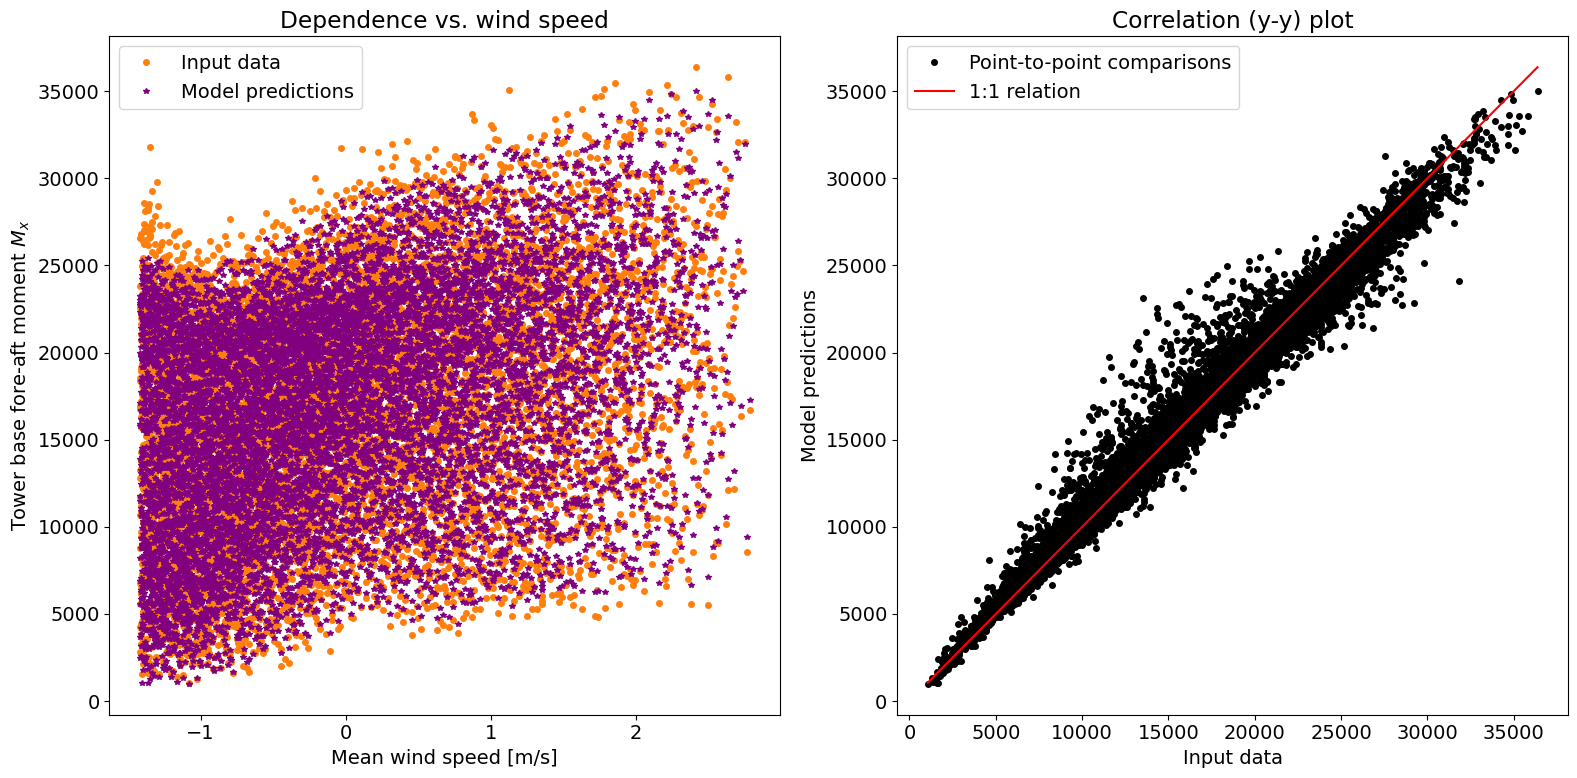

In [124]:
# plot against training data
Yout = Yscaler.inverse_transform(Mx_model.predict(Xtrain).reshape(-1, 1))
Yout_test = Yscaler.inverse_transform(Mx_model.predict(Xtest).reshape(-1, 1))


plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Tower base fore-aft moment $M_x$')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,0],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,0],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData[futTargetName]), np.max(AllTargetData[futTargetName])]),\
             np.array([np.min(AllTargetData[futTargetName]), np.max(AllTargetData[futTargetName])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

# calculate Mx based on joint distribution and given apha distribution

In [125]:
# Function to generate random wind shear exponent alpha for an array of wind speeds
def generate_wind_shear_alpha(u):
    """
    Generates wind shear exponent (alpha) from a normal distribution for each wind speed in u.

    Parameters:
    u (array-like): Array of wind speeds.

    Returns:
    alpha (array): Randomly generated values of the wind shear exponent corresponding to wind speeds.
    """
    mean_alpha = 0.1  # Mean of the normal distribution
    
    # Calculate the standard deviation for each wind speed in the array (std = min(1, 1/u))
    std_alpha = np.minimum(1, 1 / u)
    
    # Generate normally distributed random variables for alpha with corresponding std for each wind speed
    alpha = np.random.normal(mean_alpha, std_alpha)
    
    return alpha

def generate_SMC(N_samples, uniform_distribution, Weibullk, WeibullA):
    # Crude Monte-Carlo
    #SMC = np.random.rand(N_samples,dim)
    SMC = uniform_distribution.getSample(N_samples)

    U_SMC= stats.weibull_min.ppf(SMC[:,0], c=Weibullk, loc=0, scale = WeibullA) #stats.weibull_min.rvs(c= Weibullk, scale = WeibullA, size = 10000)
    MuSigmaU_SMC = MuSigmaFunc(U_SMC)
    SigmaSigma_SMC = SigmaSigmaFunc(U_SMC)
    SigmaU_SMC = LogNormDist(2, SMC[:,1], MuSigmaU_SMC, SigmaSigma_SMC)
    # wind shear alpha
    alpha_SMC = generate_wind_shear_alpha(U_SMC)
    return U_SMC, SigmaU_SMC, alpha_SMC

def generate_QMC(N_samples, uniform_distribution, Weibullk, WeibullA):
    
    # Quasi- Monte Carlo (QMC)
    QMCexperiment = ot.LowDiscrepancyExperiment(ot.SobolSequence(), uniform_distribution, N_samples, False)
    SQMC = QMCexperiment.generate()
    SQMC = np.asarray(SQMC)#.T

    U_QMC = stats.weibull_min.ppf(SQMC[:,0], c=Weibullk, loc=0, scale = WeibullA)
    MuSigmaU_QMC = MuSigmaFunc(U_QMC)
    SigmaSigma_QMC = SigmaSigmaFunc(U_QMC)
    SigmaU_QMC = LogNormDist(2, SQMC[:,1], MuSigmaU_QMC, SigmaSigma_QMC)
    # wind shear alpha
    alpha_QMC = generate_wind_shear_alpha(U_QMC)
    return U_QMC, SigmaU_QMC, alpha_QMC

In [131]:
# GENERATE RANDOM VARIATES WITH OTHER SAMPLING TECHNIQUES

N_samples = 1000
#ot.RandomGenerator.SetSeed(0)
dim = 2


uniform_distribution = ot.ComposedDistribution([ot.Uniform(0., 1.)] * dim)

QMCexperiment = ot.LowDiscrepancyExperiment(ot.SobolSequence(), uniform_distribution, N_samples, False)
SQMC = QMCexperiment.generate()
SQMC = np.asarray(SQMC)#.T
U_SMC, SigmaU_SMC, alpha_SMC = generate_SMC(N_samples, uniform_distribution, Weibullk, WeibullA)
U_QMC, SigmaU_QMC, alpha_QMC = generate_QMC(N_samples, uniform_distribution, Weibullk, WeibullA)

# get Mx predictions

# Crude Monte-Carlo
Mx_SMC = Mx_func(np.array([U_SMC.ravel(),SigmaU_SMC.ravel(),alpha_SMC.ravel()]).T)#np.array([U_SMC,SigmaU_SMC,alpha_SMC]).T
# Quasi- Monte Carlo (QMC)
Mx_QMC = Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T)

#plot of sigmaU vs U for SMC and QMC
# plt.figure()
# plt.plot(Hovsore_filtered_data['Wsp'],Hovsore_filtered_data['SigmaU'],'xk', label = 'Hovsore')
# plt.plot(U_SMC,SigmaU_SMC,'o',markersize = 4,color = 'C1', label = 'SMC')
# plt.plot(U_QMC,SigmaU_QMC,'*',markersize = 4,color = 'purple', label = 'QMC')
# plt.legend()
# plt.xlabel('U')
# plt.ylabel('$\sigma_U$')
# plt.show()

c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [127]:
# plot of alpha vs U for SMC and QMC
# plt.figure()
# plt.plot(AllInputData['U'],AllInputData['Alpha'],'xk', label = 'ML Data')
# plt.plot(U_SMC,alpha_SMC,'o',markersize = 4,color = 'C1', label = 'SMC')
# plt.plot(U_QMC,alpha_QMC,'*',markersize = 4,color = 'purple', label = 'QMC')
# plt.legend()
# plt.xlabel('U')
# plt.ylabel('alpha')
# plt.show()

# plt.rc('font', size=14)
# fig,axs = plt.subplots(1,2,figsize=(16,8))

# axs[0].plot(Hovsore_filtered_data['Wsp'],Hovsore_filtered_data['SigmaU'],'xk', label = 'Hovsore')
# axs[0].plot(U_SMC,SigmaU_SMC,'o',markersize = 4,color = 'C1', label = 'SMC')
# axs[0].plot(U_QMC,SigmaU_QMC,'*',markersize = 4,color = 'purple', label = 'QMC')
# axs[0].set_xlabel('U')
# axs[0].set_ylabel('$\sigma_U$')
# axs[0].legend()

# axs[1].plot(AllInputData['U'],AllInputData['Alpha'],'xk', label = 'ML Data')
# axs[1].plot(U_SMC,alpha_SMC,'o',markersize = 4,color = 'C1', label = 'SMC')
# axs[1].plot(U_QMC,alpha_QMC,'*',markersize = 4,color = 'purple', label = 'QMC')
# axs[1].set_xlabel('U')
# axs[1].set_ylabel('alpha')
# axs[1].legend()

# plt.tight_layout()
# plt.show()

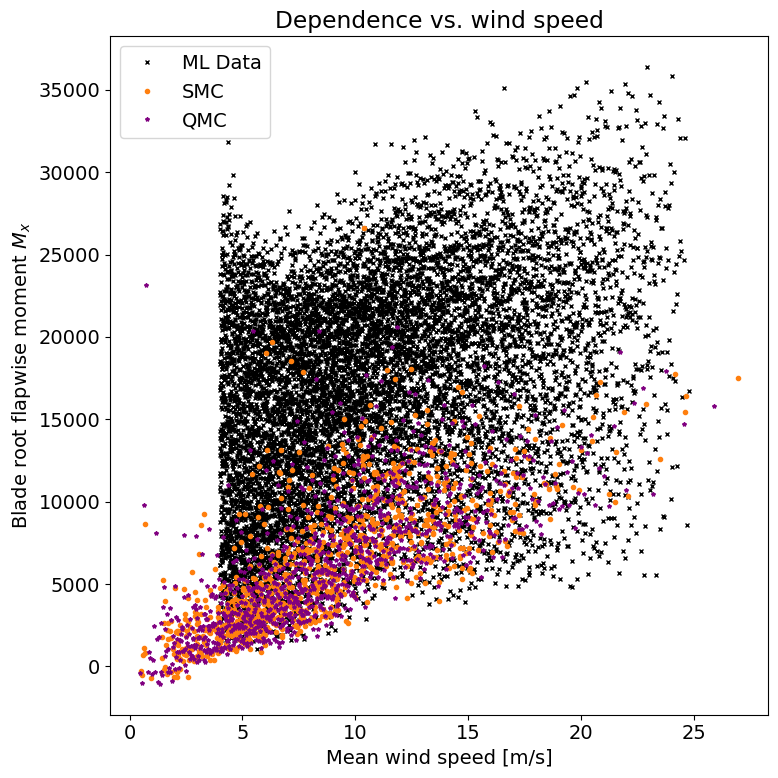

In [128]:


# plt.rc('font', size=14) 
# fig3,axs3 = plt.subplots(1,1,figsize = (8,8))
# plt.setp(axs3, title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Blade root flapwise moment $M_x$')

# axs3.plot(AllInputData['U'],AllTargetData[futTargetName],'x',markersize = 3,color = 'k', label = 'ML Data')
# axs3.plot(U_SMC,Mx_SMC,'o',markersize = 3,color = 'C1', label = 'SMC')
# axs3.plot(U_QMC,Mx_QMC,'*',markersize = 3,color = 'purple', label = 'QMC')
# axs3.legend()
# plt.tight_layout() 
# plt.show()

# lifetime damage and equivalent loads


In [135]:
# Number of reliability samples
N_Reliability = 10

# sN curve paramiters
m = 3 #Fatigue S-N curve slope
k = 4*10**12 #Fatigue strength normalization factor


#uncertanty inputs
delta = LogNormDist(2, np.random.rand(N_samples), 1, 0.3*1)
Xm = NormalDist(2, np.random.rand(N_samples), 1, 0.2*1)
Xw = NormalDist(2, np.random.rand(N_samples), 1, cov_final*1)#np.ones(N_samples)# FIX!!!!!!!!!!!!!!!

Xin = np.array([delta.ravel(), Xm.ravel(),Xw.ravel()]).T

#lifetime equivilent damage loads
LDEL_QMC_noUncertanty = (1/N_samples*np.sum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
LDEL_QMC = (1/N_samples*np.sum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

# lifetime damage
Ldamage_QMC = 1/(N_samples*k)*np.sum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)
Ldamage_QMC_noUncertanty = 1/(N_samples*k)*np.sum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m)
print(Xw.max())
print(SQMC[:,1].max())
# #lifetime equivilent damage loads cumesum
# LDEL_QMC_noUncertanty_cumesum = (1/(np.arange(N_samples))*np.cumsum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

# LDEL_QMC_cumesum = (1/(np.arange(N_samples))*np.cumsum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)

# # plot
# plt.plot(LDEL_QMC,'o',markersize = 4,color = 'k', label = 'QMC uncertainty')
# plt.plot(LDEL_QMC_noUncertanty,'o',markersize = 4,color = 'r', label = 'QMC no uncertainty')
# plt.xlabel('Number of samples')
# plt.ylabel('Lifetime equivilent damage load [kN]')
# plt.legend()


1.1071534679597406
0.9990234375


c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid f

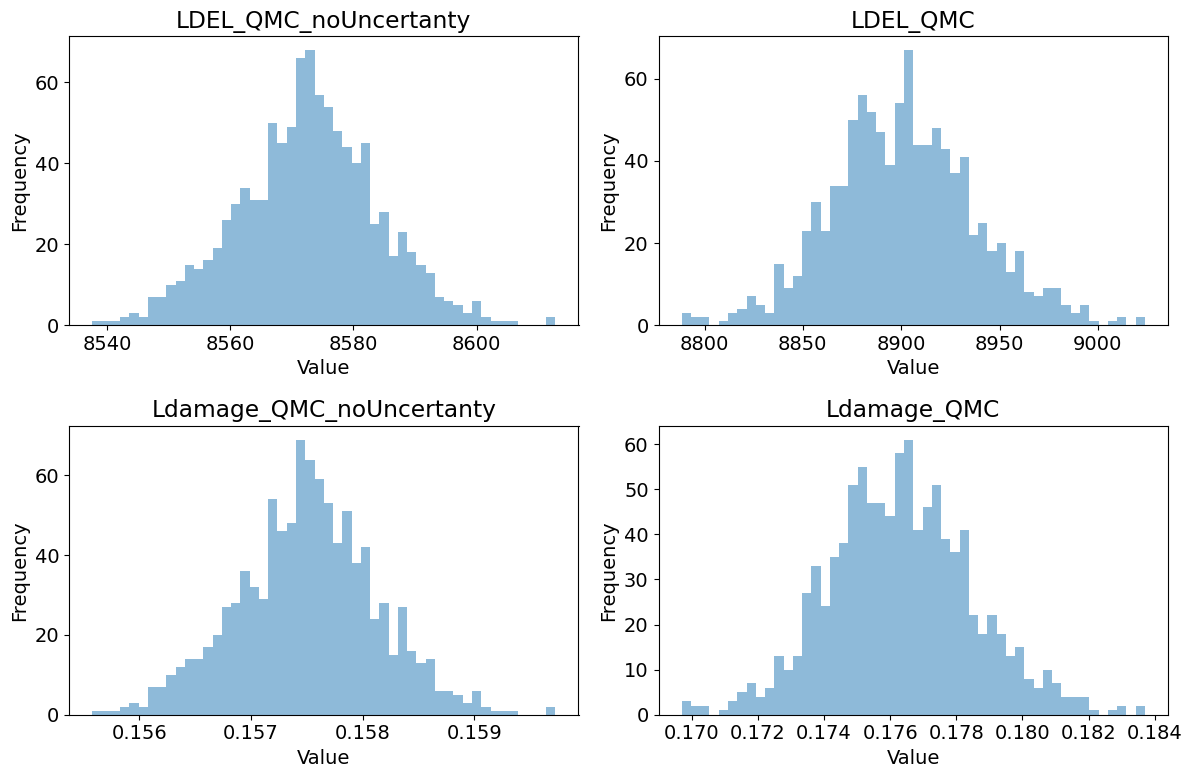

LDEL_QMC_noUncertanty_mean =  8572.721113522362
LDEL_QMC_mean =  8901.14353648368
Ldamage_QMC_noUncertanty_mean =  0.15750646374626667
Ldamage_QMC_mean =  0.1763192136716351


In [138]:
def generate_QMC_Q4(N_samples, uniform_distribution, Weibullk, WeibullA, Xw):
    
    # Quasi- Monte Carlo (QMC)
    QMCexperiment = ot.LowDiscrepancyExperiment(ot.SobolSequence(), uniform_distribution, N_samples, False)
    SQMC = QMCexperiment.generate()
    SQMC = np.asarray(SQMC)#.T

    U_QMC = stats.weibull_min.ppf(Xw, c=Weibullk, loc=0, scale = WeibullA)
    MuSigmaU_QMC = MuSigmaFunc(U_QMC)
    SigmaSigma_QMC = SigmaSigmaFunc(U_QMC)
    SigmaU_QMC = LogNormDist(2, SQMC[:,1], MuSigmaU_QMC, SigmaSigma_QMC)
    # wind shear alpha
    alpha_QMC = generate_wind_shear_alpha(U_QMC)
    return U_QMC, SigmaU_QMC, alpha_QMC


N_Reliability = 1000  # number of reliability simulations
N_samples = 10000
dim = 2
uniform_distribution = ot.ComposedDistribution([ot.Uniform(0., 1.)] * dim)

LDEL_QMC_noUncertanty_vec = np.zeros(N_Reliability)
LDEL_QMC_vec = np.zeros(N_Reliability)
Ldamage_QMC_vec = np.zeros(N_Reliability)
Ldamage_QMC_noUncertanty_vec = np.zeros(N_Reliability)

for i in range(N_Reliability):
    # uncertainty inputs
    delta = LogNormDist(2, np.random.rand(N_samples), 1, 0.3*1)
    Xm = NormalDist(2, np.random.rand(N_samples), 1, 0.2*1)
    Xw = NormalDist(2, np.random.rand(N_samples), 1, cov_final*1)
    
    Xin = np.array([delta.ravel(), Xm.ravel(),Xw.ravel()]).T

    # new wind inputs
    #U_SMC, SigmaU_SMC, alpha_SMC = generate_SMC(N_samples, uniform_distribution, Weibullk, WeibullA)
    U_QMC, SigmaU_QMC, alpha_QMC =  generate_QMC(N_samples, uniform_distribution, Weibullk, WeibullA)
# generate_QMC_Q4(N_samples, uniform_distribution, Weibullk, WeibullA, Xin[:,2])
  #  U_QMC_noUncertanty, SigmaU_QMC_noUncertanty, alpha_QMC_noUncertanty = generate_QMC(N_samples, uniform_distribution, Weibullk, WeibullA)

    # # lifetime equivalent damage loads
    # LDEL_QMC = (1/N_samples*np.sum((Xin[:,1].T*Mx_func(np.array([(U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
    # LDEL_QMC_noUncertanty = LDEL_QMC#(1/N_samples*np.sum((Mx_func(np.array([U_QMC_noUncertanty,SigmaU_QMC_noUncertanty,alpha_QMC_noUncertanty]).T).ravel())**m))**(1/m)
    
    # # lifetime damage
    # Ldamage_QMC = 1/(N_samples*k)*np.sum((Xin[:,1].T*Mx_func(np.array([(U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)
    # Ldamage_QMC_noUncertanty = Ldamage_QMC#1/(N_samples*k)*np.sum((Mx_func(np.array([U_QMC_noUncertanty,SigmaU_QMC_noUncertanty,alpha_QMC_noUncertanty]).T).ravel())**m)
    
    
    # lifetime equivalent damage loads
    LDEL_QMC_noUncertanty = (1/N_samples*np.sum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
    LDEL_QMC = (1/N_samples*np.sum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m))**(1/m)
    
    # lifetime damage
    Ldamage_QMC = 1/(N_samples*k)*np.sum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)
    Ldamage_QMC_noUncertanty = 1/(N_samples*k)*np.sum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m)
    
    # store outputs as vectors
    LDEL_QMC_noUncertanty_vec[i] = LDEL_QMC_noUncertanty
    LDEL_QMC_vec[i] = LDEL_QMC
    Ldamage_QMC_vec[i] = Ldamage_QMC
    Ldamage_QMC_noUncertanty_vec[i] = Ldamage_QMC_noUncertanty



# plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(LDEL_QMC_noUncertanty_vec, bins=50, alpha=0.5, label='LDEL_QMC_noUncertanty')
axs[0, 0].set_title('LDEL_QMC_noUncertanty')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(LDEL_QMC_vec, bins=50, alpha=0.5, label='LDEL_QMC')
axs[0, 1].set_title('LDEL_QMC')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(Ldamage_QMC_noUncertanty_vec, bins=50, alpha=0.5, label='Ldamage_QMC_noUncertanty')
axs[1, 0].set_title('Ldamage_QMC_noUncertanty')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(Ldamage_QMC_vec, bins=50, alpha=0.5, label='Ldamage_QMC')
axs[1, 1].set_title('Ldamage_QMC')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

LDEL_QMC_noUncertanty_mean = np.mean(LDEL_QMC_noUncertanty_vec)
print('LDEL_QMC_noUncertanty_mean = ', LDEL_QMC_noUncertanty_mean)

LDEL_QMC_mean = np.mean(LDEL_QMC_vec)
print('LDEL_QMC_mean = ', LDEL_QMC_mean)

Ldamage_QMC_noUncertanty_mean = np.mean(Ldamage_QMC_noUncertanty_vec)
print('Ldamage_QMC_noUncertanty_mean = ', Ldamage_QMC_noUncertanty_mean)

Ldamage_QMC_mean = np.mean(Ldamage_QMC_vec)
print('Ldamage_QMC_mean = ', Ldamage_QMC_mean)  



# # lifetime damage
# Ldamage_QMC = 1/(N_samples*k)*np.sum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)

# # no uncertanty
# Ldamage_QMC_noUncertanty = 1/(N_samples*k)*np.sum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m)

# # lifetime damage
# Ldamage_QMC_cumsum = 1/(np.arange(N_samples)*k)*np.cumsum((Xin[:,1].T*Mx_func(np.array([(Xin[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)

# # no uncertanty
# Ldamage_QMC_noUncertanty_cumsum = 1/(np.arange(N_samples)*k)*np.cumsum((Mx_func(np.array([U_QMC,SigmaU_QMC,alpha_QMC]).T).ravel())**m)

# #plot
# plt.plot(Ldamage_QMC_cumsum,'o',markersize = 4,color = 'k', label = 'QMC uncertainty')
# plt.plot(Ldamage_QMC_noUncertanty_cumsum,'o',markersize = 4,color = 'r', label = 'QMC no uncertainty')
# plt.xlabel('Number of samples')
# plt.ylabel('Lifetime accumulated damage [-]')
# plt.legend()


# Limit state function and probability of failure

Probability of failure - MC simulation: 0.0
Reliability index - MC simulation: 1.0
Number of failure events observed - MC simulation: 0
Probability of failure - QMC simulation: 0.0
Reliability index - QMC simulation: 1.0
Number of failure events observed- QMC simulation: 0


c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aletc\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


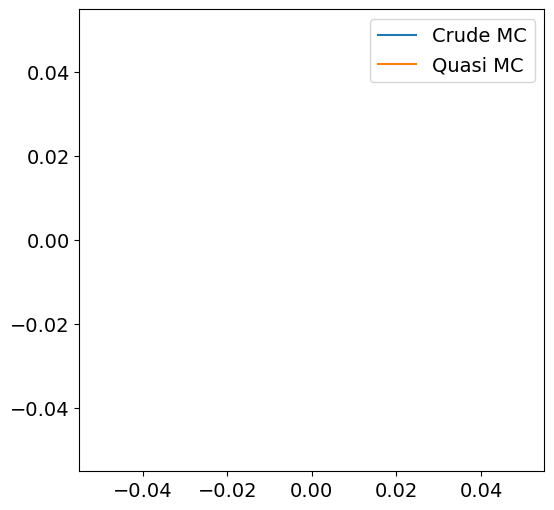

In [75]:
#limit state function
g =lambda x, U, SigmaU, alpha : x[:,0] - 1/(N_samples*k)*np.sum((x[:,1].T*Mx_func(np.array([(x[:,2].T*U),SigmaU,alpha]).T).ravel())**m)
#np.sum((x[:,1].T*Mx_func(np.array([(x[:,2].T*U_QMC),SigmaU_QMC,alpha_QMC]).T).ravel())**m)
gQMC = g(Xin,U_QMC,SigmaU_QMC,alpha_QMC)
gMC = g(Xin,U_SMC.ravel(),SigmaU_SMC.ravel(),alpha_SMC.ravel())

print('Probability of failure - MC simulation: ' + str(sum(gMC<=0)/N_samples))
print('Reliability index - MC simulation: ' + str(1-sum(gMC<=0)/N_samples))
print('Number of failure events observed - MC simulation: ' + str(sum(gMC <= 0)))

print("Probability of failure - QMC simulation: " + str(sum(gQMC<=0)/N_samples))
print("Reliability index - QMC simulation: " + str(1-sum(gQMC<=0)/N_samples))
print("Number of failure events observed- QMC simulation: " + str(sum(gQMC <= 0)))

betaMChist = stats.norm.ppf(1 - np.cumsum(gMC<=0)/np.arange(1,len(gMC)+1))
betaQMChist = stats.norm.ppf(1 - np.cumsum(gQMC<=0)/np.arange(1,len(gQMC)+1))


fig1,axs1 = plt.subplots(1,1,figsize = (6,6))
axs1.plot(betaMChist, label = 'Crude MC')
axs1.plot(betaQMChist, label = 'Quasi MC')
axs1.legend()
plt.show()